In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from base_hTCN import base_hTCN
from sklearn import metrics
import torch.distributions as dist



# Hyperparams

In [2]:
train_T = 65000
test_T = 15000
T_no = 100
M_no = 1
B_no = 2

C_den = torch.zeros(5,5)
C_den[0,1:] = 1

#C_den = torch.tensor([0]).reshape((1,1))



sub_no = C_den.shape[0]

batch_size = 1500

In [3]:
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])
#Ensyn = torch.tensor([106+213+211+99])
#Insyn = torch.tensor([1+22+36+42+19])

E_no = torch.sum(Ensyn)
I_no = torch.sum(Insyn)

C_syn_e = torch.zeros(sub_no, E_no)
C_syn_i = torch.zeros(sub_no, I_no)

E_count = 0
for s in range(sub_no):
    C_syn_e[s,E_count:E_count+Ensyn[s]] = 1
    E_count += Ensyn[s]

I_count = 0
for s in range(sub_no):
    C_syn_i[s,I_count:I_count+Insyn[s]] = 1
    I_count += Insyn[s]
    
#######
#####
#C_syn = torch.hstack((C_syn_e, C_syn_i))

# Train

In [4]:
model = base_hTCN(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_no, M_no, B_no)

model = model.float().cuda()

V_ref = np.load("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4.npy").flatten()[:]
#V_ref = np.fromfile("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")
#V_ref = V_ref[1:]

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)
print(test_V_ref.shape)

torch.Size([15000])


In [5]:
state_dict = model.state_dict()

for name, param in state_dict.items():
    # Transform the parameter as required.
    transformed_param = param * 0.25
    # Update the parameter.
    state_dict[name].copy_(transformed_param)

In [6]:
E_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")
I_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")

train_S_E = E_neural[:train_T]
train_S_I = I_neural[:train_T]
test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

train_S_E = torch.from_numpy(train_S_E)
train_S_I = torch.from_numpy(train_S_I)
test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

#######
#######
#train_S = torch.hstack((train_S_E, train_S_I)).float()
#test_S = torch.hstack((test_S_E, test_S_I)).float().cuda()

In [7]:
repeat_no = 2
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

127000
127000


In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.005)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.5)


435


In [9]:
batch_no = 40000
loss_array = np.empty((batch_no//100, 2))
#criterion = nn.MSELoss(reduction="mean")

for i in tnrange(batch_no):
    model.train()
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_S_E = train_S_E[batch_idx : batch_idx+batch_size].float().cuda()
    batch_S_I = train_S_I[batch_idx : batch_idx+batch_size].float().cuda()
    #batch_S = train_S[batch_idx : batch_idx+batch_size].cuda()
    batch_pred= model(batch_S_E, batch_S_I)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].float().cuda()

    loss = torch.var(batch_pred - batch_ref.flatten())
    #loss = torch.mean((batch_pred -  batch_ref) ** 2)
    
    loss = loss 
    
    loss.backward()
    #for name, p in model.named_parameters():
        #print(name, p.grad)

    
    optimizer.step()
    #scheduler.step()
    
    if i%50 == 0:
        model.eval()
        test_pred = model(test_S_E, test_S_I)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        #test_loss = torch.mean((test_V_ref - test_pred) ** 2)
        
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score.item(), train_score.item())
        if i%100 == 0:
            torch.save(model.state_dict(), "/media/hdd01/sklee/tcn/baseTCN_L23_Adend_sub5_b4_i"+str(i)+".pt")
            loss_array[i//100,0] = i
            loss_array[i//100,1] = test_score
            np.save("/media/hdd01/sklee/tcn/baseTCN_L23_Adend_sub5_b4_test_scores.npy", loss_array)


<ipython-input-9-59d8f1cefbb1>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 40.64596431642563 -0.008164954884110731 -0.011396646499633789
TEST 50 40.3143152973968 6.112422701853859e-05 -0.0005500316619873047
TEST 100 40.314935398195765 4.574351452446557e-05 0.00047338008880615234
TEST 150 40.310356916433584 0.00015930619943982371 0.00033724308013916016
TEST 200 40.31573967832952 2.5794497329090227e-05 -3.170967102050781e-05
TEST 250 40.31539914203791 3.424101248339362e-05 -0.0001989603042602539
TEST 300 40.31517225414566 3.9868641808271654e-05 -1.4662742614746094e-05
TEST 350 40.311900308067266 0.00012102457973062197 -0.0001684427261352539
TEST 400 40.00256605812676 0.007793617795494812 0.00820225477218628
TEST 450 32.61744842652971 0.1909708877037688 0.17532658576965332
TEST 500 29.618554667387397 0.265354154219792 0.13192838430404663
TEST 550 31.383112046057917 0.22158683438860505 0.2823135256767273
TEST 600 26.40056156913285 0.34517186583930226 0.2017086148262024
TEST 650 27.155219523344833 0.3264536557875022 0.4090237617492676
TEST 700 25.2060734027

TEST 6150 4.689970145130049 0.8836720048264188 0.8560844659805298
TEST 6200 4.906013249156975 0.878313364960003 0.83546382188797
TEST 6250 5.072775013390997 0.8741770780808182 0.6323785185813904
TEST 6300 4.83205344100207 0.8801478320348213 0.7960633039474487
TEST 6350 4.138699314532653 0.8973454885589467 0.8332003951072693
TEST 6400 4.357952151900871 0.8919072358338658 0.8087881803512573
TEST 6450 4.522825630497757 0.887817785213839 0.9117474555969238
TEST 6500 6.716910855761873 0.833396642269285 0.8697481155395508
TEST 6550 4.891712182246261 0.8786680823925455 0.8463019132614136
TEST 6600 4.401006929979162 0.8908393237060297 0.7969622611999512
TEST 6650 5.151026401461922 0.8722361644344487 0.8863548636436462
TEST 6700 4.503592070363803 0.8882948461246019 0.8363195657730103
TEST 6750 4.280507886569692 0.8938281299493943 0.8958575129508972
TEST 6800 5.022031996890915 0.8754356859497451 0.7684471607208252
TEST 6850 4.198355038582641 0.8958658137464248 0.8555675745010376
TEST 6900 5.5021

TEST 12350 4.4205490473912485 0.8903546094411205 0.8137344121932983
TEST 12400 4.421033539902039 0.8903425922908493 0.8881345391273499
TEST 12450 5.224386179069154 0.8704165801774881 0.8504213094711304
TEST 12500 4.4639550535788715 0.8892779855963664 0.8080369234085083
TEST 12550 3.8241709384155644 0.9051469146619062 0.8433155417442322
TEST 12600 4.909317528553948 0.8782314070344788 0.8633858561515808
TEST 12650 3.8140023122674167 0.9053991328798623 0.835564374923706
TEST 12700 4.162450484957958 0.8967563747745628 0.8789695501327515
TEST 12750 4.00463303647336 0.9006708106591224 0.8681076765060425
TEST 12800 4.288634762544585 0.8936265544525989 0.8887163996696472
TEST 12850 5.76862440084792 0.856917530225797 0.8467973470687866
TEST 12900 3.9512745949951182 0.9019942904156381 0.8395824432373047
TEST 12950 4.06051513478621 0.8992847352334609 0.8491379618644714
TEST 13000 4.643793243440082 0.8848173567622135 0.8498629331588745
TEST 13050 4.963855359359281 0.8768786741737536 0.836185932159

TEST 18500 4.27932792459286 0.893857397215418 0.7264811396598816
TEST 18550 4.608635455345675 0.8856893953575079 0.84637850522995
TEST 18600 4.10371420076141 0.8982132442312472 0.893728494644165
TEST 18650 3.7143882538154607 0.907869916983875 0.8823553323745728
TEST 18700 3.757259687871402 0.9068065524329196 0.8529295325279236
TEST 18750 3.918533078381306 0.9028063968630152 0.8650849461555481
TEST 18800 4.6188918143375455 0.8854350010957256 0.8214076161384583
TEST 18850 4.250232208063096 0.8945790748249132 0.7824105620384216
TEST 18900 3.833955940547038 0.9049042117048339 0.8336060047149658
TEST 18950 3.8813122975930825 0.9037296050408397 0.8622435331344604
TEST 19000 4.560651281139102 0.8868795741500712 0.8693737983703613
TEST 19050 4.25259072013437 0.8945205753164526 0.8568593263626099
TEST 19100 4.47050537324125 0.8891155143105466 0.7933589220046997
TEST 19150 4.4227885567605805 0.8902990616185557 0.7566410899162292
TEST 19200 3.96459674481932 0.9016638535694275 0.8265089988708496
T

TEST 24650 3.9805875965299626 0.9012672233884096 0.4775828719139099
TEST 24700 4.018390699909989 0.9003295715174747 0.8446481227874756
TEST 24750 3.7403546086301653 0.9072258587262518 0.8702747225761414
TEST 24800 4.582178283671058 0.88634562761873 0.8774219155311584
TEST 24850 5.1689204203682 0.8717923289032914 0.8413147330284119
TEST 24900 3.755223770219775 0.9068570504517455 0.91797935962677
TEST 24950 4.529507104562247 0.8876520608078061 0.7841039299964905
TEST 25000 4.101645684434898 0.8982645508230688 0.8456073999404907
TEST 25050 5.772073475797472 0.856831980844151 0.7887876033782959
TEST 25100 5.02072434293102 0.8754681204505156 0.8992873430252075
TEST 25150 4.393508169990604 0.8910253197205783 0.7521414160728455
TEST 25200 3.751406078968817 0.9069517428250656 0.8536586761474609
TEST 25250 5.162848562137622 0.871942932663825 0.8259997367858887
TEST 25300 4.27413796759111 0.893986126671976 0.8405394554138184
TEST 25350 3.806861116506611 0.9055762600093267 0.8895801305770874
TEST

TEST 30800 4.1383467291371 0.8973542339592774 0.7741760611534119
TEST 30850 3.996116461214085 0.9008820521315009 0.819878101348877
TEST 30900 4.024279581381077 0.9001835062561507 0.9078115820884705
TEST 30950 4.26133330913263 0.8943037278838293 0.6933029294013977
TEST 31000 4.359511502822431 0.8918685583587288 0.8648123741149902
TEST 31050 4.163723674806032 0.8967247951669084 0.7223093509674072
TEST 31100 4.048357591356095 0.899586285692672 0.8405029773712158
TEST 31150 3.911044201076465 0.9029921477454619 0.8675746321678162
TEST 31200 3.848717003538815 0.9045380846743099 0.8694214820861816
TEST 31250 4.819894489782273 0.8804494174677711 0.7680289149284363
TEST 31300 4.012745326417628 0.9004695969330587 0.8523114919662476
TEST 31350 4.804539461114963 0.8808302769673565 0.8977084159851074
TEST 31400 4.023404394292413 0.9002052140144441 0.835757851600647
TEST 31450 4.2310068792015 0.8950559315641543 0.8310593366622925
TEST 31500 4.071728935864411 0.8990065929546288 0.837324857711792
TEST

TEST 36950 4.34638536000336 0.8921941335630724 0.81843501329422
TEST 37000 4.610578451474344 0.8856412021315181 0.8950157761573792
TEST 37050 4.102680192246077 0.8982388913171262 0.9153301119804382
TEST 37100 4.676028919834836 0.8840177969558832 0.8685925006866455
TEST 37150 3.824577373314594 0.9051368336293311 0.8806980848312378
TEST 37200 4.149053708395533 0.8970886626584306 0.8109902143478394
TEST 37250 4.040686804126246 0.899776548600793 0.9084384441375732
TEST 37300 4.344811558300252 0.8922331694714162 0.8549793362617493
TEST 37350 3.6471217543998753 0.909538366199689 0.8926489353179932
TEST 37400 3.9945311505258068 0.9009213734848232 0.8416099548339844
TEST 37450 4.295160111937506 0.8934647025186925 0.7338478565216064
TEST 37500 4.410023130922481 0.890615689757124 0.8334469795227051
TEST 37550 3.8905707838787 0.9034999615706656 0.8934584259986877
TEST 37600 4.052774697050087 0.8994767256726036 0.8631516695022583
TEST 37650 4.107756606352453 0.8981129781591523 0.78290194272995
TES

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(test_V_ref.cpu().detach().numpy()[1000:5000], linewidth=1)
plt.plot(test_pred.cpu().detach().numpy()[1000:5000] - 78, linewidth=1)
plt.title("No APs: 0hz Burst")
#plt.ylim(-100,0)

#plt.savefig("/media/hdd01/sklee/tcn/Asoma_b4.png", dpi=150, bbox_inches='tight')#

torch.Size([5, 100])


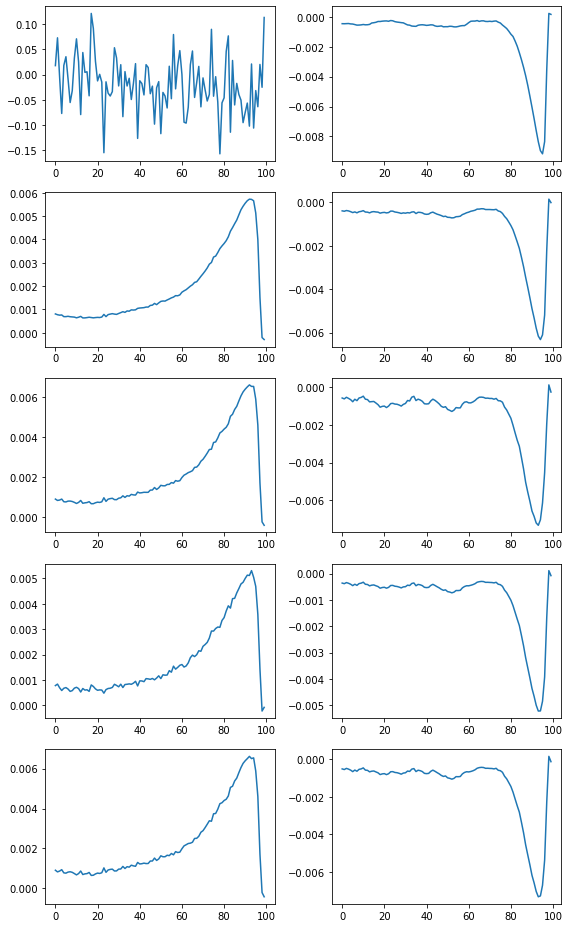

In [11]:
e_weights = torch.matmul(model.conv1_e_weights, model.conv1_e_bases)
i_weights = torch.matmul(model.conv1_i_weights, model.conv1_i_bases)
print(e_weights.shape)

fig, axs = plt.subplots(ncols=2, nrows=5, figsize = (8,13))
for row in range(5):
    axs[row, 0].plot(e_weights[row,:].cpu().detach().numpy())
    axs[row, 1].plot(i_weights[row,:].cpu().detach().numpy())
    
fig.tight_layout()
#plt.savefig("/media/hdd01/sklee/tcn/Adend_b0_filters.png", dpi=150, bbox_inches='tight')#

In [12]:
#e_weights = e_weights.cpu().detach().numpy()
for i in range(5):
    print(torch.argmax(e_weights[-i,:]))

tensor(17, device='cuda:0')
tensor(92, device='cuda:0')
tensor(93, device='cuda:0')
tensor(92, device='cuda:0')
tensor(92, device='cuda:0')


# Test

In [4]:
model = base_hTCN(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_no, M_no, B_no)

model.load_state_dict(torch.load("/media/hdd01/sklee/tcn/baseTCN_L23_sub5_b4_i34400.pt"))
model = model.float().to("cuda")

V_ref = np.load("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4.npy").flatten()[:]

test_V_ref = V_ref[train_T:train_T+test_T]


In [5]:
E_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")
I_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")

test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

test_V_final = model(test_S_E, test_S_I)

test_V_final = test_V_final.cpu().detach().numpy()


0.9545119284482774


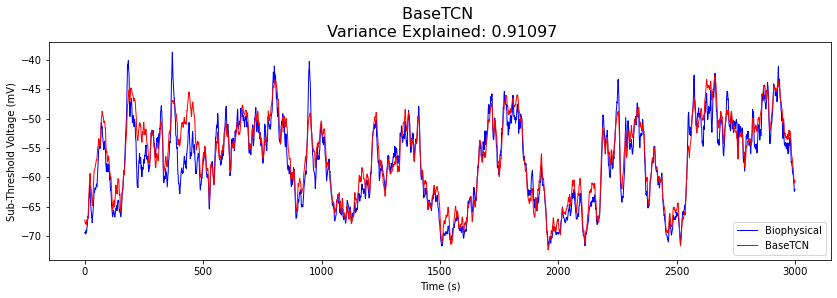

In [6]:
plt.figure(figsize = (14,4))
plt.plot(test_V_ref[5000:8000], label="Biophysical", c="blue", linewidth=1)
plt.plot(test_V_final[5000:8000]-21,label="BaseTCN", c="red", linewidth=1)
print(np.corrcoef(test_V_ref, test_V_final)[0][1])


test_score = metrics.explained_variance_score(y_true=test_V_ref,
                                                      y_pred=test_V_final,
                                                      multioutput='uniform_average')

plt.title("BaseTCN \n Variance Explained: " + str(round(test_score, 5)), fontsize = 16)
#plt.xticks(np.arange(0,8001,1000),[0,1,2,3,4,5,6,7,8])
#plt.xticks(np.arange(0,4001,1000),[0,1,2,3,4])
plt.xlabel("Time (s)")
plt.ylabel("Sub-Threshold Voltage (mV)")
plt.legend()
#plt.show()


plt.savefig("/media/hdd01/sklee/tcn/BaseTCN_L23_sub5_b4.png", dpi=150, bbox_inches='tight')#

In [12]:
#np.save("/media/hdd01/sklee/tcn/basetcn_L23_sub5_b4_test.npy", test_V_final)

In [5]:
e_weights = model.conv1_e_weights
e_bases = model.conv1_e_bases
e_prod = torch.matmul(e_weights, e_bases).cpu().detach().numpy()

i_weights = model.conv1_i_weights
i_bases = model.conv1_i_bases
i_prod = torch.matmul(i_weights, i_bases).cpu().detach().numpy()

for i in range(e_prod.shape[0]):
    e_prod[i] /= np.max(np.abs(e_prod[i]))
    i_prod[i] /= np.max(np.abs(i_prod[i]))
    e_prod[i] = np.flip(e_prod[i])
    i_prod[i] = np.flip(i_prod[i])

In [7]:
np.save("/media/hdd01/sklee/tcn/basetcn_L23_sub5_b4_e_kern.npy", e_prod)
np.save("/media/hdd01/sklee/tcn/basetcn_L23_sub5_b4_i_kern.npy", i_prod)